**Fiche d'exercice n°1**

Cette fiche d'exercices doit permettre de :
- s'entraîner au devoir de janvier
- compléter votre culture dans le domaine

La correction sera mise à disposition autour du 11/11.

**Question 1** Nous avons vu qu'il était impossible de séparer les nuages de points du TP1/partie I/B avec un perceptron une couche. Mais c'est parce que nous nous sommes limités à deux prédicteurs, l'abscisse $x$ et l'ordonnée $y$. Quels autres prédicteurs peut-on utiliser pour résoudre le problème sans ajouter de couches au perceptron ?
  

Les prédicteurs que nous pouvons également utiliser seraient une combinaison linéaire des deux premiers. Par exemple, la somme de x et y.

**Question 2** A quel modèle statistique correspond un perceptron à une couche avec une fonction d'activation sigmoïde ?
Citer une bibliothèque python qui permet d'appliquer ce modèle à un jeu de données.

pytorch bibliothèque permettant d'appliquer ce modèle

**Question 3** Combien un VGG16 contient-il de paramètres dans les couches de convolutions ? Dans les couches complètement connectées ?
Appuyer par un bout de code.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn   # pre-defined layers

from torch.utils.data import Dataset, DataLoader

# to load pre-trained models on ImageNet:
import torchvision
from torchvision import datasets, models, transforms

model = models.vgg16(pretrained = False)
print(model)

conv_weights = 0

linear_weights = 0

for module in model.modules():
  if isinstance(module, nn.Conv2d):
    for parameter in module.parameters():
      conv_weights += torch.numel(parameter)
  if isinstance(module, nn.Linear):
    for parameter in module.parameters():
      linear_weights += torch.numel(parameter)

print(conv_weights)
print(linear_weights)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question 4** Visualiser la première couche d'un VGG entraîné sur ImageNet. Commenter.

torch.Size([64, 3, 3, 3])


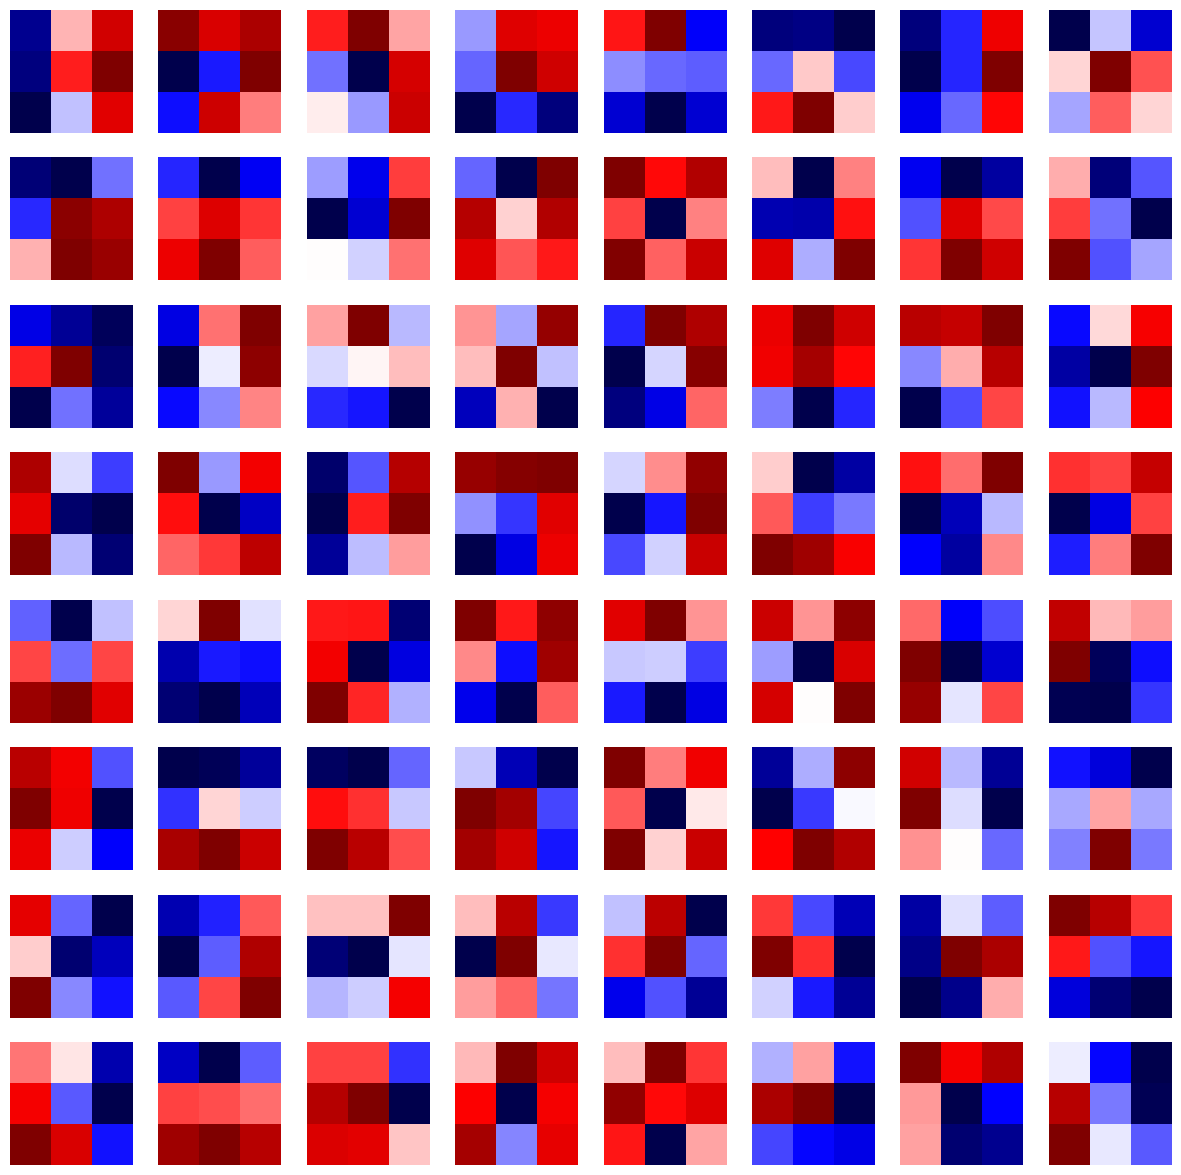

In [9]:
model = models.vgg16(pretrained = True)
first_layer = model.features[0].weight.data
print(first_layer.shape)
plt.figure(figsize=(15, 15))
for i in range(first_layer.shape[0]):
    plt.subplot(8, 8, i+1) #
    plt.imshow(first_layer[i, 0, :, :], cmap='seismic')
    plt.axis('off')
plt.show()

Extracteurs de contours et détecteurs de particularités (lignes...)

**Question 5** Quel est l'effet d'un dropout sur les couches complètement connectées ? Illustrer sur un perceptron à une couche avec quelques lignes de codes.

Le dropout permet de geler certains neurones pour éviter le surapprentissage.

In [26]:
import torch.nn.functional as F

class P1(nn.Module):

    def __init__(self):
        super(P1, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        # Dot product and bias
        x = self.fc(x)
        # Activation
        x = x.sigmoid()
        x = F.dropout(x, training=self.training)
        # Vector of "probabilities" (cat: concatenation)
        x = torch.cat((x, 1 - x), dim=1)
        return x


**Problème 1** Classification avec cibles bruitées

Les utilisateurs du Machine Learning font souvent face à un problème de qualité des cibles.
Dans ce court problème, on se propose de mesurer l'effet de cibles bruitées sur les performances en généralisation d'un CNN.


Pour une comparaison propre, nous allons d'abord scinder en trois jeux le dataset MNIST :


In [27]:
import torchvision
from torchvision import datasets
import torch
from torch.utils.data import random_split, Dataset, DataLoader
root = '/content/drive/MyDrive/TP_ENM/data'

#Définition des jeux d'apprentissage:
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])


ds_trainval = datasets.MNIST(root='MNIST', download=True, train=True)
ds_test = datasets.MNIST(root='MNIST', download=True, train=False)



len_trainval = len(ds_trainval)
len_train = round(0.8 * len_trainval)
len_val = len_trainval - len_train
subset_train, subset_val = random_split(ds_trainval,
                                [len_train, len_val],
                                generator=torch.Generator().manual_seed(1))

In [28]:
#Split aléatoire en deux datasets (80% train, 20% val):
class SubDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [29]:
ds = {}
ds['train'] = SubDataset(subset_train, tr)
ds['val'] = SubDataset(subset_val, tr)
ds['test'] = ds_test
loader = {x : DataLoader(ds[x], batch_size=32, shuffle=True, num_workers = 2) for x in ds.keys()}

TrainLoader = loader['train']
inputs, labels = next(iter(TrainLoader))

In [30]:
print(len(ds['train']))

print(len(ds['val']))

print(len(ds['test']))

48000
12000
10000


**Question 6**  Quelles sont les tailles des différents jeux de données ? A quoi sert-il de fixer le générateur de nombres aléatoires dans random_split ?

**Question 7** Reprendre le CNN du TP2/partie1 et la fonction train_model_gpu vue au TP2/partie2.
- Ajouter une procédure de sélection de modèle à partir des performances sur le jeu de validation.
- Coder une fonction test_model_gpu() qui calcule la justesse sur le jeu de test.
- Faire tourner l'apprentissage sur 50 époques, avec l'optimiser ADAM, paramétré de manière standard.

Quelles sont les performances sur le jeu de test du modèle sélectionné ? \\


In [31]:
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print(torch.cuda.get_device_name(device))
else:
  print('Change the runtime type to GPU')

Tesla T4


In [48]:
import time

import copy

N = 490

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # Here, the log is applied after the softmax:
        return F.log_softmax(x, dim=1)


dataset_sizes = {'train':len(ds['train']), 'val':len(ds['val']), 'test':len(ds['test'])}

def train_model_gpu(model, loss_fn, optimizer, num_epochs=1):
    # Record the starting time
    since = time.time()

    best_val_acc = 0
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in loader[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                labels = labels.to(device)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # At the end of each epoch, save the best model:
            if phase == "val" and epoch_acc > best_val_acc:
              best_model_wts = copy.deepcopy(model.state_dict())

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # Return the trained model
    return model, best_model_wts


model = CNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn =  nn.CrossEntropyLoss()

model, best_model_wts = train_model_gpu(model, loss_fn, optimizer, num_epochs=50)


Epoch 0/49
----------
train Loss: 0.3961 Acc: 87.36%
val Loss: 0.0850 Acc: 97.32%
Epoch 1/49
----------
train Loss: 0.1795 Acc: 94.56%
val Loss: 0.0610 Acc: 98.07%
Epoch 2/49
----------
train Loss: 0.1380 Acc: 95.95%
val Loss: 0.0546 Acc: 98.38%
Epoch 3/49
----------
train Loss: 0.1173 Acc: 96.44%
val Loss: 0.0517 Acc: 98.38%
Epoch 4/49
----------
train Loss: 0.1037 Acc: 96.83%
val Loss: 0.0481 Acc: 98.59%
Epoch 5/49
----------
train Loss: 0.0942 Acc: 97.15%
val Loss: 0.0507 Acc: 98.52%
Epoch 6/49
----------
train Loss: 0.0861 Acc: 97.29%
val Loss: 0.0484 Acc: 98.49%
Epoch 7/49
----------
train Loss: 0.0790 Acc: 97.50%
val Loss: 0.0469 Acc: 98.66%
Epoch 8/49
----------
train Loss: 0.0772 Acc: 97.59%
val Loss: 0.0431 Acc: 98.72%
Epoch 9/49
----------
train Loss: 0.0729 Acc: 97.68%
val Loss: 0.0457 Acc: 98.69%
Epoch 10/49
----------
train Loss: 0.0707 Acc: 97.74%
val Loss: 0.0450 Acc: 98.78%
Epoch 11/49
----------
train Loss: 0.0657 Acc: 97.85%
val Loss: 0.0442 Acc: 98.77%
Epoch 12/49
--

In [53]:
model.load_state_dict(best_model_wts)

TestLoader = loader['test']

def test_model_gpu(model, loss_fn):

    model.eval()

    running_loss = 0.0
    running_corrects = 0
    for input, label in loader['test']:
      input = input.to(device)
      label = label.to(device)
      output = model(input)
      loss = loss_fn(output, label)
      _, preds = torch.max(output, 1)
      running_loss += loss.item() * inputs.size(0)
      acc = torch.sum(preds == labels.data)
      acc = acc.to('cpu')
      running_corrects += acc
    loss_global = running_loss / dataset_sizes['test']
    acc_global = running_corrects.double() / dataset_sizes['test']
    return loss_global, acc_global

loss_global, acc_global = test_model_gpu(model, loss_fn)

print(loss_global)
print(acc_global)

TypeError: ignored

**Question 8** Quel est l'effet de la fonction suivante sur un batch de cibles ?

In [55]:
def flipping_label(labels, p):
  #Sélection aléatoire des composantes
  flip_probas = p * torch.ones(labels.shape)
  flip_or_not = torch.bernoulli(flip_probas) == 1
  print(flip_or_not)
  random_labels = torch.randint(0,10,labels.shape).to(device)
  labels[flip_or_not] = random_labels[flip_or_not]



labels = torch.randint(0,10,(32,)).to(device)
print(labels)

# niveau de bruit :
p = 0.5

# Après bruitage :
flipping_label(labels, p)
print(labels)

tensor([2, 7, 8, 9, 6, 1, 4, 1, 0, 5, 4, 6, 4, 4, 0, 2, 7, 8, 5, 2, 5, 7, 8, 7,
        5, 9, 7, 3, 3, 0, 5, 6], device='cuda:0')
tensor([ True,  True, False, False, False,  True, False, False,  True,  True,
        False,  True,  True,  True, False, False,  True,  True,  True, False,
        False, False,  True,  True, False, False,  True,  True,  True,  True,
         True, False])
tensor([0, 4, 8, 9, 6, 5, 4, 1, 1, 2, 4, 0, 3, 4, 0, 2, 4, 3, 8, 2, 5, 7, 4, 7,
        5, 9, 0, 7, 8, 1, 7, 6], device='cuda:0')


La fonction permet de changer la cible avec une probabilité un demi, c'est-à-dire q'une cible a une chance sur deux de voir sa valeur changer selon une loi uniforme sur 0 à 9

**Question 9** Définir une procédure d'entraînement "bruitée" à partir de flipping_labels() (ne bruiter que la phase d'entraînement). Quel est l'effet sur les performances en fonction du niveau de bruit ?

In [58]:
def train_model_gpu_proba(model, loss_fn, optimizer, num_epochs=1, p):
    # Record the starting time
    since = time.time()

    best_val_acc = 0
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in loader[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                flipping_label(labels, p)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # At the end of each epoch, save the best model:
            if phase == "val" and epoch_acc > best_val_acc:
              best_model_wts = copy.deepcopy(model.state_dict())

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # Return the trained model
    return model


model = CNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn =  nn.CrossEntropyLoss()

model = train_model_gpu_proba(model, loss_fn, optimizer, num_epochs=50, p = 0.5)

SyntaxError: ignored

**Problème 2** Le chat perturbé


Reprendre l'image de chat du TP2 et la bruiter de manière à ce que :
- le chat soit encore parfaitement reconnaissable
- le VGG16 vu au TP2 se trompe complètement de classe.

Vous pourrez par exemple dégrader la résolution et modifier localement la valeur de certains pixels. En vous renseignant un peu sur les "attaques adversariales", vous verrez comment aborder le problème par des techniques d'optimisation bien choisies. \\
L'image "disrupted_cat.jpg" du répertoire "exercises" fournit un exemple de solution. Les cellules ci-dessous permettent de le vérifier.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

model = models.vgg16(pretrained=True)
model = model.cuda()
softmx = nn.Softmax(dim=1).cuda()
model.eval()


In [ ]:
def imshow(inp, title=None, save_path=None):
    if save_path is not None:
        torch.save(inp, save_path)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

classe prédite : 333 (hamster)


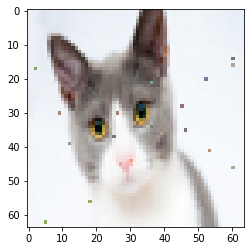

In [ ]:
## Après optimisation voici une configuration qui arrive à tromper le modèle
path = 'Ou/est/disrupted_cat.jpg'
dcat = torch.load(path)
imshow(dcat)

dcat = dcat.unsqueeze(dim=0).cuda()
output_dcat = softmx(model(dcat)).squeeze(dim=0)
pred_dcat = torch.max(output_dcat, dim=0)[1].item()
print("classe prédite : " + str(pred_dcat) + " (hamster)")